### Import required modules

In [262]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import os
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
font = {'size'   : 16}
import matplotlib
matplotlib.rc('font', **font)

### Define the file location

In [2]:
file_path = r"C:\Users\lukas\OneDrive - University of Cambridge\PhD\3DMOKE\MagnetCalibration\magnet_response_complete.h5"
print(os.path.isfile(file_path))

True


# Fit magnet hysteresis

### Extract and preprocess the data

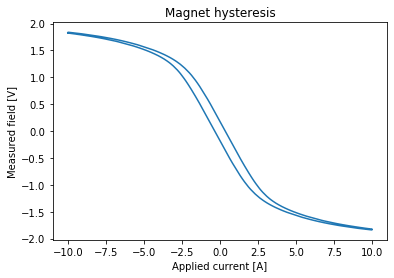

In [3]:
with h5py.File(file_path, 'r') as f:
    nnl_hp = pd.DataFrame(f['nonlinear_response/pole0/hallprobe/data'][:])
    nnl_hx = pd.DataFrame(f['nonlinear_response/pole0/hexapole/data'][:])
bins = np.arange(nnl_hp[0].iloc[0], nnl_hp[0].iloc[-1], 1/100)

nnl_hp['bins'] = pd.cut(nnl_hp[0], bins, right=False)
nnl_hp = nnl_hp.groupby('bins').mean().reset_index().drop(labels=[0,'bins'], axis=1)
nnl_hp.columns = ['hpA', 'hpB', 'hpC']
nnl_hx['bins'] = pd.cut(nnl_hx[0], bins, right=False)
nnl_hx = nnl_hx.groupby('bins').mean().reset_index().drop(labels=[0,'bins'], axis=1)
nnl_hx.columns = ['hxA', 'hxB', 'hxC']

nnl = pd.concat([nnl_hp, nnl_hx], axis=1)

# add the negative values for completion
nnl = pd.concat([nnl, -nnl])


plt.plot(nnl['hxA'], nnl['hpA'])
plt.xlabel('Applied current [A]')
plt.ylabel('Measured field [V]')
plt.title('Magnet hysteresis')

plt.savefig('Magnet hysteresis.png')

### Fit the data

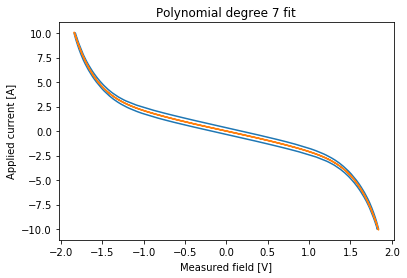

In [4]:
x = nnl['hpA'].values
y = nnl['hxA'].values

coeff = np.polyfit(x, y, 7)
hyst_fun = np.poly1d(coeff)

plt.plot(nnl['hpA'], nnl['hxA'])
plt.plot(nnl['hpA'], hyst_fun(nnl['hpA']))
plt.ylabel('Applied current [A]')
plt.xlabel('Measured field [V]')
plt.title('Polynomial degree 7 fit')
plt.savefig('Magnet hysteresis fit.png')

# Fit frequency-amplitude

### Extract the data

#### Checked:
- the amplitude is constant througout the signal, so the transient signal is completely dead
- signal is well described by it's maximal frequency and amplitude

#### Suspicions
- I think there is something happening with the input to output on the kepcos (i.e. kepco response signal) which might be slightly modified depending on the load on it.
- I need to read up on what is causing it

[8.07754443 0.56486978 0.17704617]


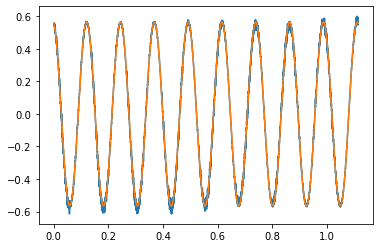

In [145]:
# check the loop
pole=0
loop = '251'
with h5py.File(file_path, 'r') as f:
    grp_loops = f['frequency_response/pole'+str(pole)]
    hx = extract_loop_data(grp_loops['loops'+loop], 'hexapole')
    hp = extract_loop_data(grp_loops['loops'+loop], 'hallprobe')
dt = extract_max_amp(hp[:, 1:])
print(dt)
t = hp[:, 0]
t-=t[0]
# plt.plot(t[-1]-t-0.18, hp[:, pole+1])
plt.plot(t, hp[:, pole+1])
plt.plot(t, dt[1]*np.cos(t*2*np.pi*dt[0]+dt[2]))

In [93]:
def extract_max_amp(data, invert_fun=None, timestep=1/10000):
    """Extracts the frequency from the loops experiment given the instrument group.
        Returns an array frequency, max amp, phase
    """
    if invert_fun is not None:
        data = invert_fun(data)
    
    # extract fft
    n = data.shape[0]
    fft = np.fft.rfft(data, axis=0) / (n / 2)
    fft_phase = np.angle(fft)
    fft_amp = np.absolute(fft)
    freq = np.fft.rfftfreq(n, d=timestep)
    
    # get the maximum amplitude
    indx = np.unravel_index(np.argmax(fft_amp, axis=None), fft_amp.shape)
    
    return np.array([freq[indx[0]], fft_amp[indx], fft_phase[indx]])

def extract_loop_data(grp, instrument):
    data = np.vstack([grp[key][instrument]['data'][:] for key in grp.keys()])
    return data


def get_frequency_data(file_path, pole='0'):
    """Gets the fourier data from the frequency response experiment for the given pole of the magnet given the file path"""
    instruments=['hallprobe', 'hexapole']
#     data_out = pd.DataFrame(columns=['hx_freq', 'hx_amp', 'hx_phase', 'hp_freq', 'hp_amp', 'hp_phase'])
    data = {key:[] for key in instruments}
    with h5py.File(file_path, 'r') as f:
        grp_loops = f['frequency_response/pole'+pole]
        n_loops = len(grp_loops.keys())
        for i, loops in enumerate(grp_loops.keys()):
            print('Loop {}/{}'.format(i, n_loops))
            for inst in instruments:
                # get the data for the instrument
                loop_data = extract_loop_data(grp_loops[loops], inst)
                # get the max amplitude
                invert_fun = hyst_fun if inst=='hallprobe' else None
                max_amp = extract_max_amp(loop_data[:, 1:], invert_fun=invert_fun, timestep = loop_data[1, 0]-loop_data[0, 0])
                data[inst].append(max_amp)
    for inst in data:
        data[inst] = np.vstack(data[inst])
    
    return data

def format_freq_data(freq_data):
    """Formats the data and gets rid of the non matching data"""
    data_out = pd.DataFrame(np.hstack((freq_data['hexapole'], freq_data['hallprobe'])), 
                            columns=['hx_freq', 'hx_amp', 'hx_phase', 'hp_freq', 'hp_amp', 'hp_phase'])
    # make sure that all of the data matches (i.e. hallprobe and hexapole frequencies corresponse)
    freq_delta = np.abs(data_out['hx_freq'] - data_out['hp_freq'])
    print('There are {} data points where frequencies do not match.'.format(np.sum(freq_delta>=1/100)))
    data_out = data_out.loc[freq_delta<1/100, :]
    # drop one of the frequencies and calculate the phase delta
    data_out.drop(columns='hp_freq', inplace=True)
    data_out.rename(columns={'hx_freq':'freq'}, inplace=True)
    data_out['phase_delta'] = (data_out['hp_phase'] - data_out['hx_phase'])%(2*np.pi)
    
    return data_out
    
# data = get_frequency_data(file_path)
freq_data = format_freq_data(data)
freq_data.head()

There are 0 data points where frequencies do not match.


,freq,hx_amp,hx_phase,hp_amp,hp_phase,phase_delta
0,0.100000,1.000000,-1.570733,0.832431,-1.724105,6.129814
1,0.100000,1.473684,-1.570796,1.299247,-1.718955,6.135027
2,0.100000,5.736842,-1.570733,5.433923,-1.651550,6.202368
3,1.485038,0.999999,-1.571178,0.575056,-2.337557,5.516807
4,1.485038,1.473683,-1.571178,0.880248,-2.354277,5.500086


### Plot the data for visualisation

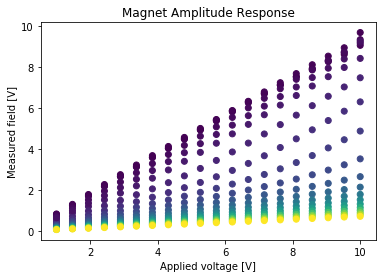

In [147]:
plt.scatter(freq_data['hx_amp'], freq_data['hp_amp'], c=freq_data['freq'])
plt.xlabel('Applied voltage [V]')
plt.ylabel('Measured field [V]')
plt.title('Magnet Amplitude Response')
plt.savefig('Amplitude_response.png')

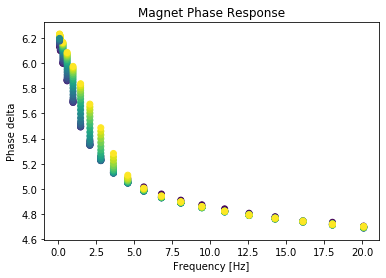

In [149]:
plt.scatter(freq_data['freq'], freq_data['phase_delta'], c=freq_data['hx_amp'])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Phase delta')
plt.title('Magnet Phase Response')
plt.savefig('Phase_response.png')

### Fit the amplitude

[0.58706939 1.04610463]
L:0.5870693905468817
R:1.046104626982885


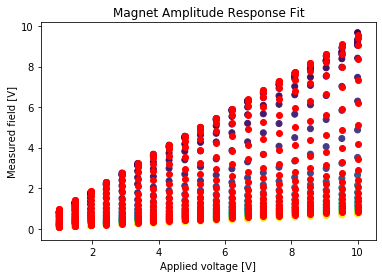

In [211]:
hp= freq_data['hp_amp'].values
f = freq_data['freq'].values
hx = freq_data['hx_amp'].values

x =np.hstack((f[:, np.newaxis], hx[:, np.newaxis]))


amp_fitting = lambda x, L, R: x[:, 1]/np.sqrt((L*x[:, 0])**2+R**2)
popt, perr = curve_fit(amp_fitting, x, hp)#, p0 = [0.01, 0.01], bounds=[[0, 0], [100, 100]])#, max_nfev=10000, diff_step=0.001)
print(popt)
amp_fun = lambda x: amp_fitting(x, *popt)
L, R = popt[0], popt[1]
print('L:{}\nR:{}'.format(L, R))
amp_inv_fun = lambda amp, freq: amp*np.sqrt((L*freq)**2+R**2)

plt.scatter(freq_data['hx_amp'], freq_data['hp_amp'], c=freq_data['freq'])
plt.scatter(freq_data['hx_amp'], amp_fun(x), c='red')

plt.xlabel('Applied voltage [V]')
plt.ylabel('Measured field [V]')
plt.title('Magnet Amplitude Response Fit')
plt.savefig('Amplitude_response_fit.png')

### Fit the phase

Lag: -0.0047277197269983695


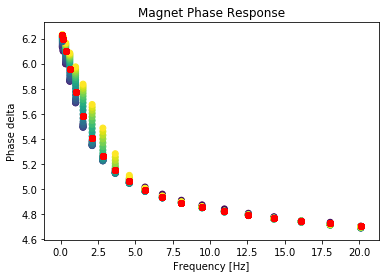

In [210]:
phase_delta = freq_data['phase_delta'].values
f = freq_data['freq'].values

delta_phase_fit = lambda x, lag: 2*np.pi-np.arctan(x*L/R)+lag*x
popt, perr = curve_fit(delta_phase_fit, f, phase_delta)
lag = popt[0]
print('Lag: {}'.format(lag))
delta_phase_fun = lambda f: delta_phase_fit(f, lag)

plt.scatter(f, phase_delta, c=freq_data['hx_amp'])
plt.scatter(f, delta_phase_fun(f), c='red')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Phase delta')
plt.title('Magnet Phase Response')
plt.savefig('Phase_response_fit.png')

# Testing the fit

### Import and plot the signal

Text(0, 0.5, 'Measurement [V]')

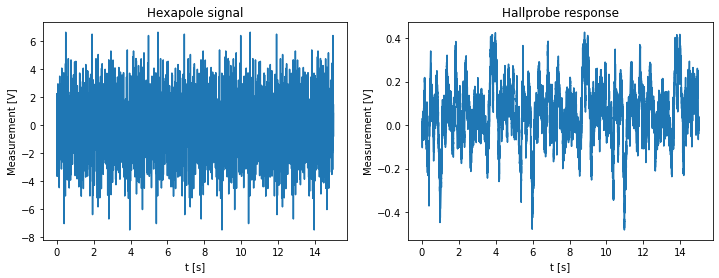

In [230]:
# get the test signal
test_num=0
with h5py.File(file_path, 'r') as f:
    hp_signal = f['test_response/test{}/hallprobe/data'.format(test_num)][:]
    hp_signal[:, 0] -= hp_signal[0, 0]
    hx_signal = f['test_response/test{}/hexapole/data'.format(test_num)][:]
    hx_signal[:, 0] -= hx_signal[0, 0]

fig = plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(hx_signal[:, 0], hx_signal[:, 1])
plt.xlabel('t [s]')
plt.ylabel('Measurement [V]')
plt.title('Hexapole signal')

plt.subplot(1, 2, 2)
plt.title('Hallprobe response')
plt.plot(hp_signal[:, 0], hp_signal[:, 1])
plt.xlabel('t [s]')
plt.ylabel('Measurement [V]')

### Try to reconstruct the hexapole signal from the hallprobe

In [243]:
def get_required_input(hp_signal, hyst_fun=None, amp_fun=None, phase_fun=None, cutoff_freq=100):
    """Gets the required hex signal given the measured/desired hp signal"""
    t = hp_signal[:, 0] 
    signal = hp_signal[:, 1:]
    
    # first invert the hysteresis
    signal_nohyst = hyst_fun(signal)
    # do fft on the signal and extract the frequencies
    n = signal_nohyst.shape[0]
    fft = np.fft.rfft(signal_nohyst, axis=0) / (n / 2)
    fft_phase = np.angle(fft)
    fft_amp = np.absolute(fft)
    freq = np.fft.rfftfreq(n, d=timestep)
    
    # kill all of the ampilitudes of signals higher than 100Hz
    fft_amp[freq>cutoff_freq, :] = 0
    
    # apply the amplitude and phase functions
    f = freq[:, np.newaxis]
    hx_amp = amp_fun(fft_amp, f)
    hx_phase = fft_phase + phase_fun(f)
    
    # reconstruct the signal
    hx_fft = hx_amp*np.exp(1j*hx_phase)
    hx_signal = np.fft.irfft(hx_fft, axis=0, n=n) * (n/2)
    
    return np.hstack((t[:, np.newaxis], hx_signal))

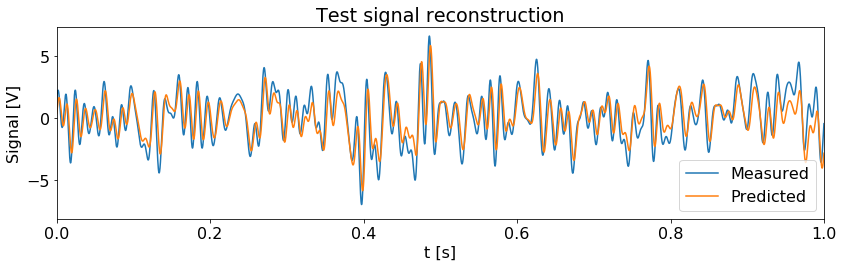

In [263]:

inverted_hx = get_required_input(hp_signal, 
                                 hyst_fun=hyst_fun,
                                amp_fun=amp_inv_fun,
                                phase_fun=delta_phase_fun)


fig = plt.figure(figsize=(12, 4))
plt.plot(hx_signal[:, 0], hx_signal[:, 1], label='Measured')
plt.plot(inverted_hx[:, 0], -inverted_hx[:, 1], label='Predicted')
plt.legend(loc='lower right')
plt.xlabel('t [s]')
plt.ylabel('Signal [V]')
plt.title('Test signal reconstruction')
plt.xlim([0, 1])
plt.tight_layout()
plt.savefig('Test_signal_reconstruction.png', dpi=200)